# YOLOV8预训练模型预测-Python API-摄像头实时画面

同济子豪兄 2023-4-25

## `注意，本代码需要在本地，连接摄像头运行，不能在云GPU平台运行`

## 导入工具包

In [1]:
import cv2
import numpy as np
import time
from tqdm import tqdm

from ultralytics import YOLO

import matplotlib.pyplot as plt
%matplotlib inline 

## 载入模型

In [2]:
model = YOLO('checkpoint/Triangle_215_yolov8n_pose_pretrain.pt')
# model = YOLO('checkpoint/Triangle_215_yolov8x_pose_p6_pretrain.pt')

## 可视化配置

In [3]:
# 框（rectangle）可视化配置
bbox_color = (150, 0, 0)             # 框的 BGR 颜色
bbox_thickness = 2                   # 框的线宽

# 框类别文字
bbox_labelstr = {
    'font_size':1,         # 字体大小
    'font_thickness':2,    # 字体粗细
    'offset_x':0,          # X 方向，文字偏移距离，向右为正
    'offset_y':-10,        # Y 方向，文字偏移距离，向下为正
}

In [4]:
# 关键点 BGR 配色
kpt_color_map = {
    0:{'name':'angle_30', 'color':[255, 0, 0], 'radius':6},      # 30度角点
    1:{'name':'angle_60', 'color':[0, 255, 0], 'radius':6},      # 60度角点
    2:{'name':'angle_90', 'color':[0, 0, 255], 'radius':6},      # 90度角点
}

# 骨架连接 BGR 配色
skeleton_map = [
    {'srt_kpt_id':0, 'dst_kpt_id':1, 'color':[196, 75, 255], 'thickness':2},        # 30度角点-60度角点
    {'srt_kpt_id':0, 'dst_kpt_id':2, 'color':[180, 187, 28], 'thickness':2},        # 30度角点-90度角点
    {'srt_kpt_id':1, 'dst_kpt_id':2, 'color':[47,255, 173], 'thickness':2},         # 60度角点-90度角点
]

## 逐帧处理函数

In [5]:
def process_frame(img_bgr):
    
    '''
    输入摄像头画面 bgr-array，输出图像 bgr-array
    '''
    
    # 记录该帧开始处理的时间
    start_time = time.time()
    
    results = model(img_bgr)
    
    # 预测框的个数
    num_bbox = len(results[0].boxes.cls)
    
    # 预测框的 xyxy 坐标
    bboxes_xyxy = results[0].boxes.xyxy.cpu().numpy().astype('uint32') 
    
    # 关键点的 xy 坐标
    bboxes_keypoints = results[0].keypoints.cpu().numpy().astype('uint32')
    
    for idx in range(num_bbox): # 遍历每个框

        # 获取该框坐标
        bbox_xyxy = bboxes_xyxy[idx] 

        # 获取框的预测类别（对于关键点检测，只有一个类别）
        bbox_label = results[0].names[0]

        # 画框
        img_bgr = cv2.rectangle(img_bgr, (bbox_xyxy[0], bbox_xyxy[1]), (bbox_xyxy[2], bbox_xyxy[3]), bbox_color, bbox_thickness)

        # 写框类别文字：图片，文字字符串，文字左上角坐标，字体，字体大小，颜色，字体粗细
        img_bgr = cv2.putText(img_bgr, bbox_label, (bbox_xyxy[0]+bbox_labelstr['offset_x'], bbox_xyxy[1]+bbox_labelstr['offset_y']), cv2.FONT_HERSHEY_SIMPLEX, bbox_labelstr['font_size'], bbox_color, bbox_labelstr['font_thickness'])

        bbox_keypoints = bboxes_keypoints[idx] # 该框所有关键点坐标和置信度

        # 画该框的骨架连接
        for skeleton in skeleton_map:

            # 获取起始点坐标
            srt_kpt_id = skeleton['srt_kpt_id']
            srt_kpt_x = bbox_keypoints[srt_kpt_id][0]
            srt_kpt_y = bbox_keypoints[srt_kpt_id][1]

            # 获取终止点坐标
            dst_kpt_id = skeleton['dst_kpt_id']
            dst_kpt_x = bbox_keypoints[dst_kpt_id][0]
            dst_kpt_y = bbox_keypoints[dst_kpt_id][1]

            # 获取骨架连接颜色
            skeleton_color = skeleton['color']

            # 获取骨架连接线宽
            skeleton_thickness = skeleton['thickness']

            # 画骨架连接
            img_bgr = cv2.line(img_bgr, (srt_kpt_x, srt_kpt_y),(dst_kpt_x, dst_kpt_y),color=skeleton_color,thickness=skeleton_thickness)

        # 画该框的关键点
        for kpt_id in kpt_color_map:
            kpt_color = kpt_color_map[kpt_id]['color']
            kpt_radius = kpt_color_map[kpt_id]['radius']
            kpt_x = bbox_keypoints[kpt_id][0]
            kpt_y = bbox_keypoints[kpt_id][1]
            img_bgr = cv2.circle(img_bgr, (kpt_x, kpt_y), kpt_radius, kpt_color, -1)
            
    # 记录该帧处理完毕的时间
    end_time = time.time()
    # 计算每秒处理图像帧数FPS
    FPS = 1/(end_time - start_time)

    # 在画面上写字：图片，字符串，左上角坐标，字体，字体大小，颜色，字体粗细
    FPS_string = 'FPS  '+str(int(FPS)) # 写在画面上的字符串
    img_bgr = cv2.putText(img_bgr, FPS_string, (25, 60), cv2.FONT_HERSHEY_SIMPLEX, 1.25, (255, 0, 255), 2)
    
    return img_bgr

## 摄像头拍摄单帧画面

In [26]:
# 获取摄像头，0为电脑默认摄像头，1为外接摄像头
cap = cv2.VideoCapture(0)

# 拍照
time.sleep(3) # 运行本代码后等几秒拍照
# 从摄像头捕获一帧画面
success, frame = cap.read()

cap.release() # 关闭摄像头
cv2.destroyAllWindows() # 关闭图像窗口

In [27]:
frame.shape

(720, 1280, 3)

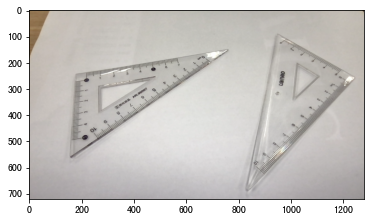

In [28]:
plt.imshow(frame[:,:,::-1])
plt.show()

## 单帧画面关键点检测预测


0: 384x640 2 sjb_rects, 108.8ms
Speed: 0.9ms preprocess, 108.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)


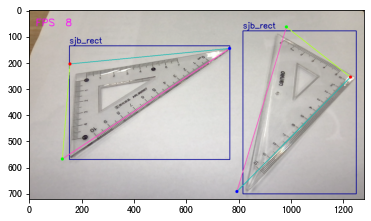

In [29]:
img_bgr = process_frame(frame)

plt.imshow(img_bgr[:,:,::-1])
plt.show()

## 摄像头实时画面逐帧处理（模板）

In [6]:
# 调用摄像头逐帧实时处理模板
# 不需修改任何代码，只需修改process_frame函数即可
# 同济子豪兄 2021-7-8

# 导入opencv-python
import cv2
import time

# 获取摄像头，传入0表示获取系统默认摄像头
cap = cv2.VideoCapture(1)

# 打开cap
cap.open(0)

# 无限循环，直到break被触发
while cap.isOpened():
    
    # 获取画面
    success, frame = cap.read()
    
    if not success: # 如果获取画面不成功，则退出
        print('获取画面不成功，退出')
        break
    
    ## 逐帧处理
    frame = process_frame(frame)
    
    # 展示处理后的三通道图像
    cv2.imshow('my_window',frame)
    
    key_pressed = cv2.waitKey(60) # 每隔多少毫秒毫秒，获取键盘哪个键被按下
    # print('键盘上被按下的键：', key_pressed)

    if key_pressed in [ord('q'),27]: # 按键盘上的q或esc退出（在英文输入法下）
        break
    
# 关闭摄像头
cap.release()

# 关闭图像窗口
cv2.destroyAllWindows()


0: 384x640 2 sjb_rects, 111.3ms
Speed: 1.5ms preprocess, 111.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 108.7ms
Speed: 0.4ms preprocess, 108.7ms inference, 0.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 112.7ms
Speed: 0.6ms preprocess, 112.7ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.5ms
Speed: 0.4ms preprocess, 102.5ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.0ms
Speed: 0.4ms preprocess, 102.0ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.4ms
Speed: 0.6ms preprocess, 102.4ms inference, 0.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 105.7ms
Speed: 0.5ms preprocess, 105.7ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 106.3ms
Speed: 0.5ms preprocess, 106.3ms inference, 0.6ms 


0: 384x640 2 sjb_rects, 102.8ms
Speed: 0.5ms preprocess, 102.8ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 103.2ms
Speed: 0.5ms preprocess, 103.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.5ms
Speed: 0.5ms preprocess, 102.5ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 101.9ms
Speed: 0.5ms preprocess, 101.9ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.6ms
Speed: 0.5ms preprocess, 102.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.2ms
Speed: 0.5ms preprocess, 102.2ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.6ms
Speed: 0.5ms preprocess, 102.6ms inference, 0.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 sjb_rects, 102.8ms
Speed: 0.5ms preprocess, 102.8ms inference, 0.6ms 

## 按`q`键或`Esc`键关闭画面